In [1]:
import re
import os
#import fileio
import string
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
USER_CSV = os.path.join(ROOT_DIR, 'output', 'users', 'objs', '2022-02-06', 'user-objs-orig.csv')
LOCATIONS_JSON = os.path.join(ROOT_DIR, 'input', 'locations.json')

#locations = fileio.read_content(LOCATIONS_JSON, 'json')
locations = pd.read_json(LOCATIONS_JSON)[0]

INPUT = {
    'user_id'        : pd.Int64Dtype(),
    'protected'      : pd.BooleanDtype(),
    'screen_name'    : pd.StringDtype(),
    'location'       : pd.StringDtype(),
    'name'           : pd.StringDtype(),
    'description'    : pd.StringDtype(),
    'verified'       : pd.BooleanDtype(),
    'created_at'     : pd.StringDtype(),
    'statuses_count' : pd.Int64Dtype(),
    'friends_count'  : pd.Int64Dtype(),
    'followers_count': pd.Int64Dtype(),
}

OUTPUT = {
    'user_id'        : pd.Int64Dtype(),
    'protected'      : pd.BooleanDtype(),
    'screen_name'    : pd.StringDtype(),
    'location'       : pd.StringDtype(),
    'created_at'     : dt.datetime,
}

#user_df = pd.read_csv(USER_CSV, dtype=INPUT)
user_df = pd.read_csv('C:\\Users\\AndreaHrelja\\Documents\\Faks\\twitter_scraper\\output\\users\\objs\\2022-02-03\\user-objs.csv')
user_df = user_df[user_df['protected'] == False]
user_df['created_at'] = pd.to_datetime(user_df['created_at'], format='%a %b %d %H:%M:%S %z %Y') # 30s
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1649613 entries, 0 to 1788233
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype              
---  ------           --------------    -----              
 0   user_id          1649613 non-null  int64              
 1   location         954700 non-null   object             
 2   screen_name      1649613 non-null  object             
 3   name             1646580 non-null  object             
 4   statuses_count   1649613 non-null  int64              
 5   friends_count    1649613 non-null  int64              
 6   followers_count  1649613 non-null  int64              
 7   description      1167333 non-null  object             
 8   created_at       1649613 non-null  datetime64[ns, UTC]
 9   verified         1649613 non-null  bool               
 10  protected        1649613 non-null  bool               
dtypes: bool(2), datetime64[ns, UTC](1), int64(4), object(4)
memory usage: 129.0+ MB


<AxesSubplot:>

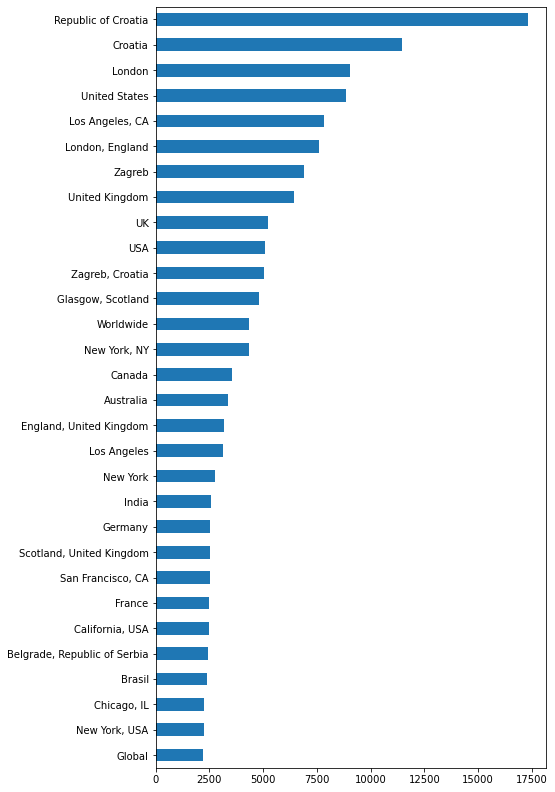

In [6]:
user_df.location.value_counts(ascending=False).head(30)[::-1].plot.barh(figsize=(7, 14))

In [7]:
accepted_chars = string.ascii_lowercase + 'čšćžđ'
diacritics = {
    'č': 'c', 
    'ć': 'c', 
    'đ': 'd', 
    'š': 's', 
    'ž': 'z'
}


def clean_location(location):
    if location == '':
        return location
    
    new_location = location
    location_names = ('hrvatska', 'croatia', 'croacia', 'croatie', 'republic of croatia', 'republika hrvatska')
    
    if re.search(r'[ ]+', location):
        new_location = new_location.replace(re.search(r'[ ]+', location).group(), ' ').strip()
    
    for name in location_names:
        if new_location.lower() == name:
            return 'Hrvatska'
    
        for char in location.lower():
            if char not in accepted_chars + ' ':
                new_location = new_location.replace(char, '')
        
        if name in location.lower():
            new_location = new_location.replace(name, '')
        new_location = new_location.strip()
        
    if new_location == '':
        new_location = 'Hrvatska'
    return new_location.title()


def is_croatian(location):
    if location == '':
        return False

    for old, new in diacritics.items():
        if old in location:
            location = location.replace(old, new)
                
    global locations
    for loc in locations:        
        if location in loc or location.lower() in loc.lower():
            return True
        
        _clean_location = clean_location(location).lower()
        _clean_loc = clean_location(loc).lower()
        if (_clean_location in _clean_loc
            or _clean_loc in _clean_location):
            return True

        if (loc.replace(' ', '') in location.replace(' ', '')
            or _clean_location.replace(' ', '') in _clean_loc.replace(' ', '')
            or location.replace(' ', '') in loc.replace(' ', '')
            or _clean_loc.replace(' ', '') in _clean_location.replace(' ', '')):
            return True
    
    return False

user_df['clean_location'] = user_df['location'].fillna('').transform(clean_location)
user_df['is_croatian']   = user_df['location'].fillna('').transform(is_croatian)

UnboundLocalError: local variable 'loc' referenced before assignment

In [ ]:
user_df

In [ ]:
croatian_df = user_df[(user_df['is_croatian'] == True) & (user_df['clean_location'] != 'Europe')]

croatian_df.groupby('clean_location').size() \
    .sort_values(ascending=False).head(25) \
    .plot.bar(
        title='Distribution of Croatian locations collected from Twitter users', 
        figsize=(25, 7), 
        rot=45, 
        logy=True, 
        color='#f8cecc',
        edgecolor='black'
    )

plt.xlabel(None)
plt.show()

In [ ]:
df[
    (df['is_croatian'] == False)
    & (df['location'] != '<NA>')
].groupby('location').size() \
 .sort_values(ascending=False).head(50) \
 .iloc[::-1].plot.barh(title='Non-Croatian locations',figsize=(14, 20))
plt.show()

In [ ]:
len(df[df['is_croatian'] == True])

In [ ]:
df = df.drop_duplicates('user_id')
df[
    (df['is_croatian'] == True)
    & (df['protected'] == False)
    & (df['statuses_count'] > 10)
    & (df['friends_count'] > 10)
    & (df['friends_count'] < 5000)
    & (df['followers_count'] > 10)
    & (df['followers_count'] < 5000)
].sort_values(by='friends_count', ascending=False) #.to_csv('new_baseline_user_ids.csv', encoding='utf-8', index=False)

In [ ]:
# output_baseline_ids

output_df = df[
    (df['is_croatian'] == True)
    & (df['protected'] == False)
    & (df['statuses_count'] > 10)
    & (df['friends_count'] > 10)
    & (df['friends_count'] < 5000)
    & (df['followers_count'] > 10)
    & (df['followers_count'] < 5000)
    | (df['screen_name'].isin(('ViliBeros', 'nbakic')))
].sort_values(by='followers_count')

#output_df.user_id.to_json('../../output/new_baseline-user-ids.json', orient='records')
output_df.head()
output_df[output_df['screen_name'] == 'novilisthr']

In [ ]:
import re
df['clean_location'] = df['clean_location'].transform(lambda x: x.replace(re.search('[ ]+', x).group(), ' ') if re.search('[ ]+', x) else x)
list(df[df['is_croatian'] == True].groupby('clean_location').size().sort_values(ascending=False).index)